### Import

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr
import datetime
import geopandas as gpd

import tensorflow as tf
import cv2
# import glob
# import os

import tensorflow as tf
from keras import layers, models

In [3]:

import geemap
import ee
ee.Authenticate()
ee.Initialize(project='static-potion-450322-u2') # this is the project for Ag Genius for porter.olson11@gmail.com


### Data

#### Get y & direction

In [28]:
import geopandas as gpd
gdf=gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson')
gdf

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,fips,geometry
0,40,093,01101831,0500000US40093,40093,Major,Major County,OK,Oklahoma,06,2473438557,7651009,40093,"POLYGON ((-98.96033 36.50691, -98.8437 36.5063..."
1,30,051,01720036,0500000US30051,30051,Liberty,Liberty County,MT,Montana,06,3703651373,44411471,30051,"POLYGON ((-111.40902 48.21954, -111.27531 48.2..."
2,17,189,01785150,0500000US17189,17189,Washington,Washington County,IL,Illinois,06,1457120178,3386079,17189,"POLYGON ((-89.70424 38.41578, -89.69676 38.425..."
3,48,139,01383856,0500000US48139,48139,Ellis,Ellis County,TX,Texas,06,2423586107,41965719,48139,"POLYGON ((-97.08706 32.5493, -97.08509 32.5492..."
4,21,213,00516953,0500000US21213,21213,Simpson,Simpson County,KY,Kentucky,06,606511222,5930956,21213,"POLYGON ((-86.76329 36.64891, -86.75134 36.727..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,40,129,01101852,0500000US40129,40129,Roger Mills,Roger Mills County,OK,Oklahoma,06,2955524813,13688537,40129,"POLYGON ((-100.0004 35.88123, -99.97211 35.888..."
196,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,16069,"POLYGON ((-117.06278 46.36529, -117.06128 46.3..."
197,26,063,01622974,0500000US26063,26063,Huron,Huron County,MI,Michigan,06,2165275137,3369019054,26063,"MULTIPOLYGON (((-83.45224 43.85635, -83.4474 4..."
198,20,021,00484980,0500000US20021,20021,Cherokee,Cherokee County,KS,Kansas,06,1521791029,8951464,20021,"POLYGON ((-95.07517 37.33994, -94.90482 37.339..."


In [29]:
import polars as pl
import pandas as pd

natl=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')


# Add FIPS column by zero-padding ANSI codes and concatenating
natl = natl.with_columns([
    pl.col("State ANSI").cast(str).str.zfill(2).alias("State_FIPS"),
    pl.col("County ANSI").cast(str).str.zfill(3).alias("County_FIPS"),
])

natl = natl.with_columns([
    (pl.col("State_FIPS") + pl.col("County_FIPS")).alias("fips")
])


natl=natl.select(['Year','fips','Value'])
natl=natl.rename({'Value':'yield'})

natl=natl.to_pandas()


valid_fips=pd.DataFrame(gdf['fips'])
valid_fips['Index']=valid_fips.index

yields = valid_fips.merge(natl, on=['fips'], how='left')
yields = yields.dropna()
yields = yields.sort_values(by=['Year', 'Index'], ascending=True)
yields = yields[(yields['Year'] > 2018) & (yields['Year'] < 2024)]

yields = yields[~yields['Index'].isin([119, 176])]

y=yields['yield']


In [30]:
# Ensure y is a NumPy array
import numpy as np
y = np.array(y)

# Define chunk size
chunk_size = 198

# Split y into 5 parts
nineteen     = y[0*chunk_size : 1*chunk_size]  # 2019
twenty       = y[1*chunk_size : 2*chunk_size]  # 2020
twenty_one   = y[2*chunk_size : 3*chunk_size]  # 2021
twenty_two   = y[3*chunk_size : 4*chunk_size]  # 2022
twenty_three = y[4*chunk_size : 5*chunk_size]  # 2023


In [31]:
dir_1=np.sign(twenty-nineteen)
dir_2=np.sign(twenty_one-twenty)
dir_3=np.sign(twenty_two-twenty_one)
dir_4=np.sign(twenty_three-twenty_two)

# First, concatenate vertically
directions = np.concatenate([dir_1, dir_2, dir_3, dir_4], axis=0)

# Then reshape to (792, 1)
directions = directions.reshape(-1, 1)


In [32]:
directions

array([[ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
      

In [39]:
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\directions.npy', directions)


### Get X from previous data

In [33]:
X=np.load(file=r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy", mmap_mode='r')

In [34]:
X.shape

#need to split them in chunks of 198 on the first axis (990)

(990, 46, 128, 128, 10)

In [35]:
#we split it into chunks of 198

chunks = np.split(X, indices_or_sections=5, axis=0)
X_2019, X_2020, X_2021, X_2022, X_2023 = chunks


In [37]:
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2019.npy', X_2019)
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2020.npy', X_2020)
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2021.npy', X_2021)
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2022.npy', X_2022)
np.save(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2023.npy', X_2023)

In [38]:
#clear memory

del X_2019, X_2020, X_2021, X_2022, X_2023
import gc
gc.collect()

4404

### Get data training Ready

In [40]:
import numpy as np
import tensorflow as tf


# Set channel ordering globally
tf.keras.backend.set_image_data_format('channels_last')

def pair_gen():
    # Load arrays with memory mapping - data stays on disk
    X_2019 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2019.npy', mmap_mode='r')
    X_2020 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2020.npy', mmap_mode='r')
    X_2021 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2021.npy', mmap_mode='r')
    X_2022 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2022.npy', mmap_mode='r')
    X_2023 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2023.npy', mmap_mode='r')
    directions = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\directions.npy', mmap_mode='r')
    
    # Generate pairs - only the specific slices get loaded into RAM
    for i in range(198):
        x = np.stack([X_2019[i], X_2020[i]], axis=0)
        yield x.astype(np.float32), directions[i].item()
        
    for i in range(198):
        x = np.stack([X_2020[i], X_2021[i]], axis=0)
        yield x.astype(np.float32), directions[198 + i].item()
        
    for i in range(198):
        x = np.stack([X_2021[i], X_2022[i]], axis=0)
        yield x.astype(np.float32), directions[396 + i].item()
        
    for i in range(198):
        x = np.stack([X_2022[i], X_2023[i]], axis=0)
        yield x.astype(np.float32), directions[594 + i].item()


        
# === 2. Dataset pipeline ===
dataset = tf.data.Dataset.from_generator(
    pair_gen,
    output_signature=(
        tf.TensorSpec(shape=(2, 46, 128, 128, 10), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# Convert labels from [-1, 0, 1] → [0, 1, 2]
def remap_label(x, y):
    return x, tf.cast((y + 1), tf.int32)

raw_dataset = dataset.map(remap_label).shuffle(500,seed=42)
train_size = int(0.8 * 792)


train_ds = raw_dataset.take(train_size).batch(2).repeat().prefetch(tf.data.AUTOTUNE)
val_ds = raw_dataset.skip(train_size).batch(1)


### Classication

In [41]:

# Model C-1.2
input_shape = (2, 46, 128, 128, 10)
inputs = layers.Input(shape=input_shape)

# Combine 2 years into 20 channels
x = layers.Reshape((46, 128, 128, 20))(inputs)

x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2))(x)
x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 3, 3))(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# 3 output classes
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs, outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2, 46, 128,     │             0 │
│                                 │ 128, 10)               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 46, 128, 128,   │             0 │
│                                 │ 20)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 46, 128, 128,   │        17,312 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 46, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 46, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 46, 64, 64,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 46, 21, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2596608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │   332,365,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,660,323 (1.24 GB)

 Trainable params: 332,660,323 (1.24 GB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\pred-class-with-2-years.keras',               # save path
    monitor='val_loss',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [43]:
batch_size = 2

history = model.fit(
    train_ds,
    validation_data=val_ds,         # keep this
    epochs=50,
    steps_per_epoch=train_size // batch_size,
    validation_steps=158,

    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4612 - loss: 1.8772
Epoch 1: val_loss improved from inf to 0.70905, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\pred-class-with-2-years.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.4613 - loss: 1.8746 - val_accuracy: 0.5443 - val_loss: 0.7091
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6034 - loss: 0.6928
Epoch 2: val_loss improved from 0.70905 to 0.56638, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\pred-class-with-2-years.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.6034 - loss: 0.6929 - val_accuracy: 0.7848 - val_loss: 0.5664
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7166 - loss: 0.6071
Epoch 3: val_loss improved from 0.56638 to 0.45287, saving model to C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_pre

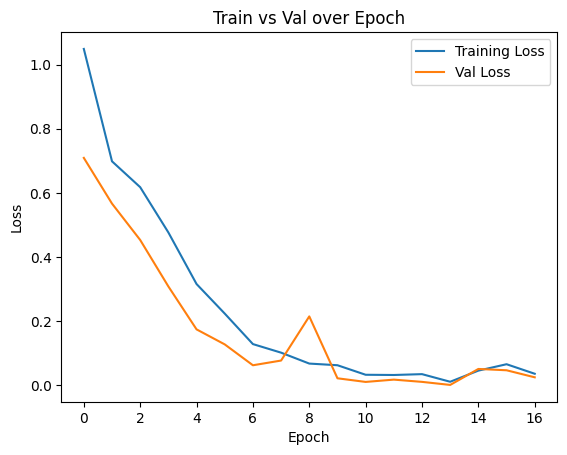

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.legend()
plt.title('Train vs Val over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Predict and Eval

Might need to restart kernel and run from this point onwards bc of RAM

In [4]:
import numpy as np
import tensorflow as tf

# Load the model
model = models.load_model(r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\models\pred-class-with-2-years.keras")

# Create the same dataset pipeline as before (for predictions)
def pair_gen():
    # Load arrays with memory mapping - data stays on disk
    X_2019 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2019.npy', mmap_mode='r')
    X_2020 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2020.npy', mmap_mode='r')
    X_2021 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2021.npy', mmap_mode='r')
    X_2022 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2022.npy', mmap_mode='r')
    X_2023 = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\X_2023.npy', mmap_mode='r')
    directions = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\directions.npy', mmap_mode='r')
    
    # Generate pairs - only the specific slices get loaded into RAM
    for i in range(198):
        x = np.stack([X_2019[i], X_2020[i]], axis=0)
        yield x.astype(np.float32), directions[i].item()
        
    for i in range(198):
        x = np.stack([X_2020[i], X_2021[i]], axis=0)
        yield x.astype(np.float32), directions[198 + i].item()
        
    for i in range(198):
        x = np.stack([X_2021[i], X_2022[i]], axis=0)
        yield x.astype(np.float32), directions[396 + i].item()
        
    for i in range(198):
        x = np.stack([X_2022[i], X_2023[i]], axis=0)
        yield x.astype(np.float32), directions[594 + i].item()

# Create dataset for predictions
dataset = tf.data.Dataset.from_generator(
    pair_gen,
    output_signature=(
        tf.TensorSpec(shape=(2, 46, 128, 128, 10), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

# Convert labels from [-1, 0, 1] → [0, 1, 2] (same as training)
def remap_label(x, y):
    return x, tf.cast((y + 1), tf.int32)

# Apply the same preprocessing as training but DON'T shuffle
prediction_dataset = dataset.map(remap_label)

# Batch the data for prediction (you can use larger batch sizes for inference)
prediction_ds = prediction_dataset.batch(4).prefetch(tf.data.AUTOTUNE)

# Make predictions
print("Making predictions...")
y_pred_probs = model.predict(prediction_ds)

# Get predicted classes (0, 1, 2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Convert back to original labels (-1, 0, 1) if needed
y_pred_original = y_pred_classes - 1

# Load true labels for comparison
directions = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\Pairs_Classification\directions.npy')
y_true = directions  # Original labels (-1, 0, 1)
y_true_classes = y_true + 1  # Converted labels (0, 1, 2)

print(f"Predictions shape: {y_pred_probs.shape}")
print(f"Predicted classes (0,1,2): {y_pred_classes}")
print(f"Predicted original labels (-1,0,1): {y_pred_original}")
print(f"True labels: {y_true}")

Making predictions...
198/198 ━━━━━━━━━━━━━━━━━━━━ 137s 693ms/step
Predictions shape: (792, 3)
Predicted classes (0,1,2): [2 2 0 2 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 2 2 2 0 0 0 2 2 2 0 2 0 2 0 0 0 2 0
 2 2 2 0 2 0 0 0 2 2 0 0 2 0 2 2 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 0 0 2 2 2 2
 0 2 2 2 2 2 0 0 1 2 0 0 0 2 2 2 0 0 0 0 0 2 2 2 2 0 0 0 2 0 2 2 0 2 2 2 0
 2 0 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 0 0 2 0 2 0 0 0 0 2 2 2 2 0 0
 0 2 0 2 2 2 0 0 2 0 0 2 0 0 0 2 0 0 2 2 0 2 2 0 2 2 2 2 0 2 0 2 2 0 2 2 2
 2 0 0 2 2 0 0 2 0 2 2 0 2 2 0 2 0 2 2 0 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0
 0 2 1 0 2 2 2 2 2 2 2 0 2 2 0 0 2 0 2 2 2 2 2 2 2 2 0 2 0 0 0 2 2 0 2 2 2
 2 2 2 2 0 2 0 2 0 0 2 0 2 2 0 0 0 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2
 0 0 0 2 2 0 0 2 2 0 0 0 2 0 2 0 2 0 2 2 2 0 2 0 2 2 2 2 2 2 0 0 0 2 2 2 0
 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 2 0 0 0 2 2 0 2 2 0 0 2 2 0 2 2 2 0 2 2 0 2
 0 0 0 0 0 2 0 0 0 2 0 2 0 2 2 2 0 2 2 2 0 0 0 0 2 2 0 0 2 0 2 2 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 

c:\Users\porter77.BYU\AppData\Local\anaconda3\envs\default_dev\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Classification metrics for 3-class problem
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print results
print("3-Class Classification Results:")
print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print("\nConfusion Matrix:")
print("Labels: 0=Decrease, 1=No Change, 2=Increase")
print(conf_matrix)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=['Decrease (-1)', 'No Change (0)', 'Increase (1)']))

3-Class Classification Results:
Accuracy:   0.9962
Precision:  0.9962
Recall:     0.9962
F1 Score:   0.9962

Confusion Matrix:
Labels: 0=Decrease, 1=No Change, 2=Increase
[[361   0   3]
 [  0   3   0]
 [  0   0 425]]

Detailed Classification Report:
               precision    recall  f1-score   support

Decrease (-1)       1.00      0.99      1.00       364
No Change (0)       1.00      1.00      1.00         3
 Increase (1)       0.99      1.00      1.00       425

     accuracy                           1.00       792
    macro avg       1.00      1.00      1.00       792
 weighted avg       1.00      1.00      1.00       792



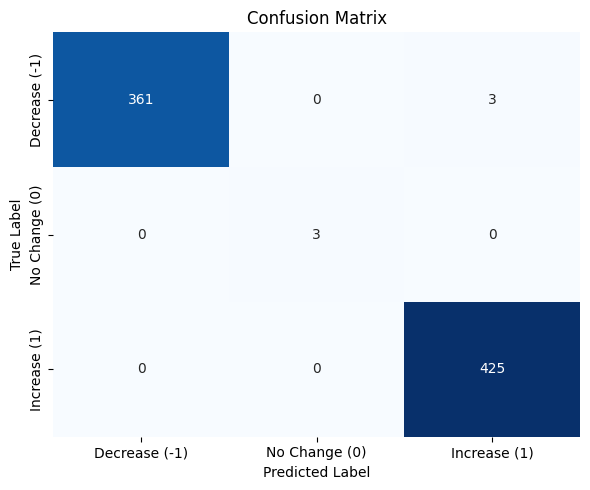

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Decrease (-1)', 'No Change (0)', 'Increase (1)'],
            yticklabels=['Decrease (-1)', 'No Change (0)', 'Increase (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


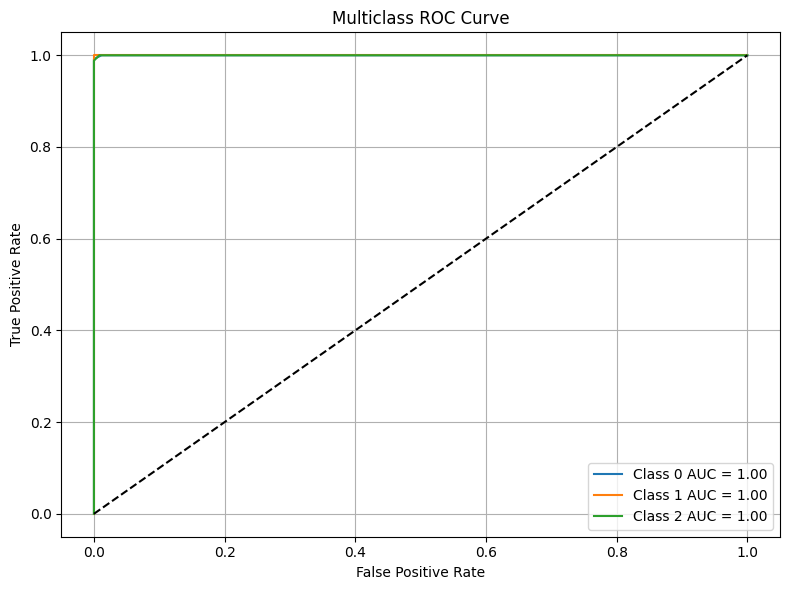

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true_classes, classes=[0, 1, 2])
n_classes = y_true_binarized.shape[1]

# y_pred_probs should be shape (n_samples, 3)
# If not already softmax output, apply softmax manually
# y_pred_probs = tf.nn.softmax(logits, axis=1).numpy()

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    auc_score = roc_auc_score(y_true_binarized[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} AUC = {auc_score:.2f}")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title("Multiclass ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


output the predicted labels

In [13]:
# Convert from 0, 1, 2 → -1, 0, 1
mapped_preds = y_pred_classes - 1

# Save to CSV as integers
np.savetxt("predicted_directions.csv", mapped_preds, delimiter=",", fmt='%d')


In [14]:
mapped_preds.shape

(792,)